# 1. Looking at old_stft and new_stft

In [1]:
import numpy as np
from scipy import io
import h5py
import matplotlib.pyplot as plt

# old_stft = io.loadmat('old_stft.mat')# , {'new_stft_real': new_stft_real, 'new_stft_imag': new_stft_imag})old_stft = h5py.File("old_stft.mat", "r")
old_stft = h5py.File("old_stft.mat", "r")
stft_real_old = np.asarray(old_stft['old_stft_real'])
stft_imag_old = np.asarray(old_stft['old_stft_imag'])

# save new stft data
new_stft = io.loadmat('new_stft.mat')# , {'new_stft_real': new_stft_real, 'new_stft_imag': new_stft_imag})
stft_real_new = new_stft['stft_real_new']
stft_imag_new = new_stft['stft_imag_new']


In [2]:
stft_real_old.shape

(51, 65, 129, 16)

In [3]:
stft_imag_old.shape

(51, 65, 129, 16)

In [4]:
stft_real_new.shape

(51, 65, 129, 16)

In [5]:
stft_imag_new.shape

(51, 65, 129, 16)

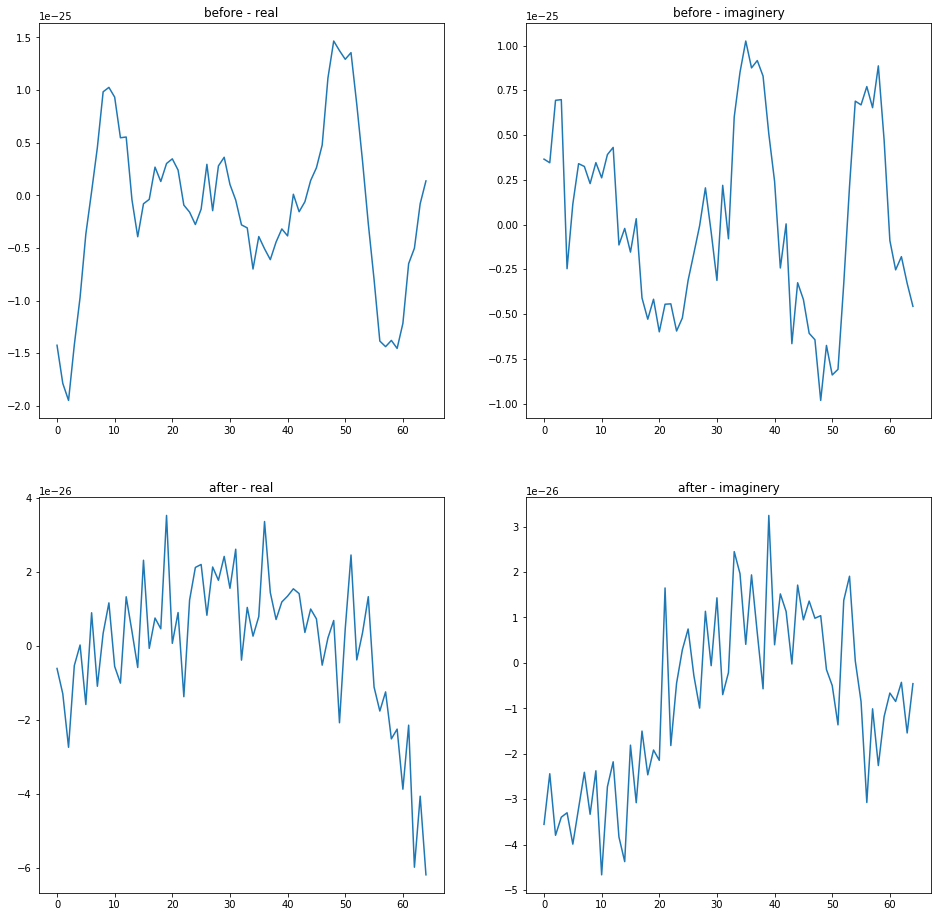

In [20]:
beam_num = 24
segment_num = 63
k = 4

fig, axes = plt.subplots(2, 2, figsize = (16,16))
axes[0, 0].plot(stft_real_old[beam_num, :, segment_num, k]) # is this correct?
axes[0, 0].set_title('before - real')
axes[0, 1].plot(stft_imag_old[beam_num, :, segment_num, k])
axes[0, 1].set_title('before - imaginery')

axes[1, 0].plot(stft_real_new[beam_num, :, segment_num, k]) # is this correct?
axes[1, 0].set_title('after - real')
axes[1, 1].plot(stft_imag_new[beam_num, :, segment_num, k])
axes[1, 1].set_title('after - imaginery')
plt.show()

# 2. Looking at training and validation data